In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns

# --- Project paths (adjust BASE if needed) ---
BASE = Path(r"c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project")
DATA = BASE / "data"
PROC_DIR = DATA / "processed_images"
LABELS_CSV = DATA / "labels.csv"
MANIFEST_CSV = DATA / "preprocess_manifest.csv"  # from your preprocessing notebook
OUT_EDA = BASE / "results" / "eda"
OUT_EDA.mkdir(parents=True, exist_ok=True)
SPLITS_DIR = DATA / "splits"
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

print("BASE:", BASE)
print("PROC_DIR:", PROC_DIR)
print("LABELS_CSV:", LABELS_CSV)
print("MANIFEST_CSV:", MANIFEST_CSV)
print("EDA out:", OUT_EDA)
print("Splits dir:", SPLITS_DIR)

# --- Helpers ---
def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    return sorted([p.name for p in folder.iterdir() if p.is_file() and p.suffix.lower() in exts])

def load_image_rgb(name: str) -> Image.Image:
    im = Image.open(PROC_DIR / name).convert("RGB")
    return ImageOps.exif_transpose(im)

def draw_grid_overlay(im: Image.Image, vec64: np.ndarray, n=8, color=(0,255,0)):
    im = im.copy()
    w, h = im.size
    gw, gh = w//n, h//n
    draw = ImageDraw.Draw(im)
    # grid
    for j in range(1, n): draw.line([(j*gw,0),(j*gw,h)], fill=(255,255,255), width=1)
    for i in range(1, n): draw.line([(0,i*gh),(w,i*gh)], fill=(255,255,255), width=1)
    # positives
    vec = np.array(vec64, int).reshape(n*n)
    for i in range(n):
        for j in range(n):
            idx = i*n + j
            if vec[idx] == 1:
                x1,y1 = j*gw, i*gh
                x2,y2 = (j+1)*gw, (i+1)*gh
                draw.rectangle([x1,y1,x2,y2], outline=color, width=3)
    return im

BASE: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project
PROC_DIR: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\processed_images
LABELS_CSV: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\labels.csv
MANIFEST_CSV: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\preprocess_manifest.csv
EDA out: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results\eda
Splits dir: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\splits


In [2]:
# Load labels
labels = pd.read_csv(LABELS_CSV)
cell_cols = [f"c{i:02d}" for i in range(1, 65)]

# Ensure columns exist and are int
for c in cell_cols:
    if c not in labels.columns:
        labels[c] = 0
labels[cell_cols] = labels[cell_cols].fillna(0).astype(int)

# Manifest (optional but useful)
manifest = pd.read_csv(MANIFEST_CSV) if MANIFEST_CSV.exists() else None

# Files present on disk
disk_files = list_images(PROC_DIR)
disk_set = set(disk_files)

# Basic checks
labeled_images = set(labels["image"].astype(str))
unlabeled_on_disk = sorted(list(disk_set - labeled_images))
missing_on_disk = sorted(list(labeled_images - disk_set))

print("Processed images on disk:", len(disk_files))
print("Images with labels      :", len(labeled_images))
print("Unlabeled images        :", len(unlabeled_on_disk))
print("Labeled-but-missing     :", len(missing_on_disk))

if unlabeled_on_disk[:5]: print("Examples unlabeled:", unlabeled_on_disk[:5])
if missing_on_disk[:5]: print("WARNING missing files:", missing_on_disk[:5])

# Restrict to intersection (safe set)
usable = sorted(list(labeled_images & disk_set))
labels = labels[labels["image"].isin(usable)].reset_index(drop=True)
print("Usable labeled images:", labels["image"].nunique())


Processed images on disk: 426
Images with labels      : 426
Unlabeled images        : 0
Labeled-but-missing     : 0
Usable labeled images: 426


=== Dataset summary ===
Images: 426
Total positive cells: 7300
Positive rate (cells): 0.26775234741783055


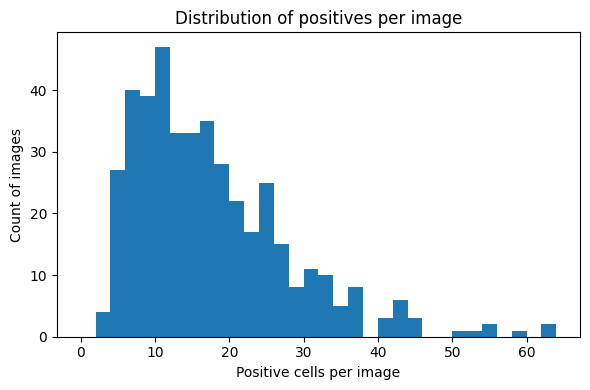

Images with ≥1 positive cell: 426 / 426


In [3]:
# Positives per image
labels["pos_count"] = labels[cell_cols].sum(axis=1)

print("=== Dataset summary ===")
print("Images:", labels["image"].nunique())
print("Total positive cells:", int(labels["pos_count"].sum()))
print("Positive rate (cells):",
      float(labels[cell_cols].values.sum()) / (labels.shape[0]*64 + 1e-9))

# Show distribution of positive cells per image
plt.figure(figsize=(6,4))
plt.hist(labels["pos_count"], bins=range(0, 65, 2))
plt.xlabel("Positive cells per image")
plt.ylabel("Count of images")
plt.title("Distribution of positives per image")
plt.tight_layout()
plt.savefig(OUT_EDA / "positives_per_image_hist.png", dpi=150)
plt.show()

# Fraction of images with any positive
print("Images with ≥1 positive cell:",
      int((labels["pos_count"] > 0).sum()), "/", labels.shape[0])


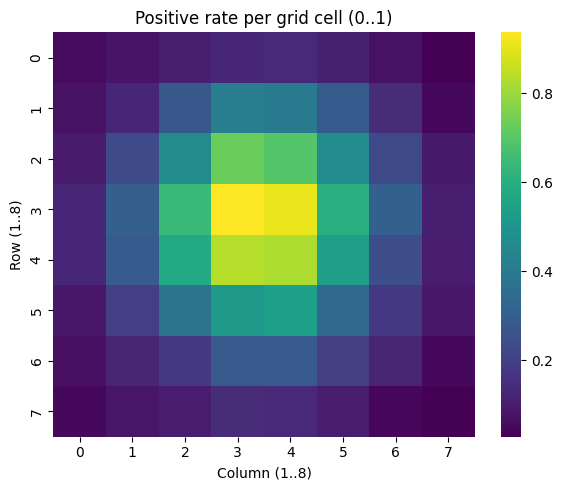

Top 5 cells: ['c28', 'c29', 'c36', 'c37', 'c20'] [np.float64(0.937), np.float64(0.906), np.float64(0.836), np.float64(0.826), np.float64(0.73)]
Bottom 5 cells: ['c57', 'c16', 'c63', 'c64', 'c08'] [np.float64(0.049), np.float64(0.047), np.float64(0.045), np.float64(0.031), np.float64(0.028)]


In [4]:
# Compute per-cell positive rate
rates = labels[cell_cols].mean(axis=0).values.reshape(8,8)

plt.figure(figsize=(6,5))
sns.heatmap(rates, annot=False, cmap="viridis", cbar=True)
plt.title("Positive rate per grid cell (0..1)")
plt.xlabel("Column (1..8)")
plt.ylabel("Row (1..8)")
plt.tight_layout()
plt.savefig(OUT_EDA / "cell_positive_rate_heatmap.png", dpi=150)
plt.show()

# Also print top/bottom cells
flat = rates.flatten()
order_idx = np.argsort(-flat)
top5 = order_idx[:5]
bot5 = order_idx[-5:]
def idx_to_c(idx): return f"c{idx+1:02d}"
print("Top 5 cells:", [idx_to_c(i) for i in top5], [round(flat[i],3) for i in top5])
print("Bottom 5 cells:", [idx_to_c(i) for i in bot5], [round(flat[i],3) for i in bot5])


In [5]:
# Save a few overlays (TP-looking examples: images with many positives, and with few)
show_many = labels.sort_values("pos_count", ascending=False).head(6)
show_few  = labels.sort_values("pos_count", ascending=True).head(6)

def save_overlays(df_sel, tag):
    saved = 0
    for _, row in df_sel.iterrows():
        name = row["image"]
        vec = row[cell_cols].values
        im = load_image_rgb(name)
        over = draw_grid_overlay(im, vec, color=(0,255,0))
        out_path = OUT_EDA / f"{tag}_{name}"
        try:
            over.save(out_path)
            saved += 1
        except Exception as e:
            print("save error:", name, e)
    print(f"Saved {saved} overlays to {OUT_EDA} (tag={tag})")

save_overlays(show_many, "manypos")
save_overlays(show_few, "fewpos")


Saved 6 overlays to c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results\eda (tag=manypos)
Saved 6 overlays to c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results\eda (tag=fewpos)


In [11]:
# === Adaptive stratified Train/Val/Test split by image (robust) ===
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
import numpy as np

rng = np.random.default_rng(42)

def try_stratified_split(X, y, test_size=0.3, val_size=0.5, random_state=42):
    """
    Return X_train, X_val, X_test using stratification on y when feasible.
    Falls back to non-stratified if y has <2 classes or any class count <2.
    """
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) < 2 or counts.min() < 2:
        # Not stratifiable
        ss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, temp_idx = next(ss.split(X))
        X_train, X_temp = X[train_idx], X[temp_idx]
        # split temp into val/test
        ss2 = ShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state+1)
        val_idx, test_idx = next(ss2.split(X_temp))
        return X_train, X_temp[val_idx], X_temp[test_idx], False

    # 1) train vs temp
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, temp_idx = next(sss1.split(X, y))
    X_train, y_train = X[train_idx], y[train_idx]
    X_temp,  y_temp  = X[temp_idx],  y[temp_idx]

    # 2) temp -> val/test
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state+1)
    val_idx, test_idx = next(sss2.split(X_temp, y_temp))
    return X_train, X_temp[val_idx], X_temp[test_idx], True

def adaptive_bins_from_poscount(pos_counts, min_per_class=2):
    """
    Try quantile bins: 5 -> 4 -> 3 -> 2.
    Ensure each bin has >= min_per_class and at least 2 bins remain.
    Returns an integer vector y (bin labels) or None if not possible.
    """
    pc = np.asarray(pos_counts)
    for k in [5, 4, 3, 2]:
        try:
            # qcut handles ties; duplicates='drop' reduces bins if edges equal
            y, edges = pd.qcut(pc, q=k, labels=False, retbins=True, duplicates='drop')
            counts = pd.Series(y).value_counts().sort_index()
            # filter out bins with too few samples by merging via re-qcut
            if (counts < min_per_class).any() or counts.size < 2:
                continue
            return y.astype(int)
        except Exception:
            continue
    return None

# Build an adaptive stratification target
pos_counts = labels["pos_count"].to_numpy()

# First try multi-bin quantile stratification
y_quant = adaptive_bins_from_poscount(pos_counts, min_per_class=2)

# If that fails, try binary stratification: any-positive vs none
y_binary = (pos_counts > 0).astype(int)
binary_ok = np.unique(y_binary, return_counts=True)[1].min() >= 2

# Decide which y to use
if y_quant is not None:
    y_used = y_quant
    y_mode = "quantile-multiclass"
else:
    if binary_ok:
        y_used = y_binary
        y_mode = "binary(any_positive)"
    else:
        y_used = None
        y_mode = "none"

X_all = labels["image"].to_numpy()
print(f"Stratification mode selected: {y_mode}")

# Perform split
if y_used is not None:
    X_train, X_val, X_test, strat_ok = try_stratified_split(X_all, y_used, test_size=0.1, val_size=0.50, random_state=42)
else:
    # Final fallback: fully random split
    ss = ShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    train_idx, temp_idx = next(ss.split(X_all))
    X_train, X_temp = X_all[train_idx], X_all[temp_idx]
    ss2 = ShuffleSplit(n_splits=1, test_size=0.50, random_state=43)
    val_idx, test_idx = next(ss2.split(X_temp))
    X_val, X_test = X_temp[val_idx], X_temp[test_idx]
    strat_ok = False

print(f"Train images: {len(X_train)}")
print(f"Val images  : {len(X_val)}")
print(f"Test images : {len(X_test)}")
print(f"Used stratification? {strat_ok}")

# Save splits
pd.Series(X_train).to_csv(SPLITS_DIR / "train_images.csv", index=False, header=False)
pd.Series(X_val).to_csv(SPLITS_DIR / "val_images.csv", index=False, header=False)
pd.Series(X_test).to_csv(SPLITS_DIR / "test_images.csv", index=False, header=False)

# --- Split sanity: show class balance for chosen y (if strat used) ---
def split_stats(name, imgs):
    sub = labels[labels["image"].isin(set(imgs))]
    rate = sub[[c for c in labels.columns if c.startswith("c")]].to_numpy().mean()
    print(f"{name:5s} | n={sub.shape[0]:4d} | cell_pos_rate={rate:.4f} | pos/img mean={sub['pos_count'].mean():.2f}")

split_stats("TRAIN", X_train)
split_stats("VAL",   X_val)
split_stats("TEST",  X_test)

# If we used a strat target, show its distribution too
if y_used is not None:
    def dist(name, imgs):
        idx = labels["image"].isin(set(imgs))
        cls, cnt = np.unique(y_used[idx], return_counts=True)
        return dict(zip(map(int, cls), map(int, cnt)))
    print("Class dist (by selected y):")
    print("  TRAIN:", dist("TRAIN", X_train))
    print("  VAL  :", dist("VAL",   X_val))
    print("  TEST :", dist("TEST",  X_test))

Stratification mode selected: quantile-multiclass
Train images: 383
Val images  : 21
Test images : 22
Used stratification? True
TRAIN | n= 383 | cell_pos_rate=0.2681 | pos/img mean=17.16
VAL   | n=  21 | cell_pos_rate=0.2507 | pos/img mean=16.05
TEST  | n=  22 | cell_pos_rate=0.2784 | pos/img mean=17.82
Class dist (by selected y):
  TRAIN: {0: 85, 1: 74, 2: 73, 3: 83, 4: 68}
  VAL  : {0: 5, 1: 4, 2: 4, 3: 4, 4: 4}
  TEST : {0: 5, 1: 4, 2: 4, 3: 5, 4: 4}
